# PLAN

- [x] Acquisition
    - [x] Select what list of repos to scrape.
    - [x] Get requests from the site.
    - [x] Save responses to csv.
- [x] Preparation
    - [x] Prepare the data for analysis.
- [ ] Exploration
    - [ ] Answer the following prompts:
        - [x] What are the most common words in READMEs?
        - [ ] What does the distribution of IDFs look like for the most common words? - @JASON
        - [ ] Does the length of the README vary by language? - @CHAD
        - [ ] Do different languages use a different number of unique words? - @DD
- [ ] Modeling
    - [ ] Transform the data for machine learning; use language to predict.
    - [ ] Fit several models using different text repressentations.
        - [ ] TF-IDF @JASON
        - [ ] Logistic Regression @DD
        - [ ] K-Nearest Neighbor @DD
    - [ ] Build a function that will take in the text of a README file, and makes a prediction of language.
- [ ] Delivery
    - [ ] Github repo
        - [x] This notebook.
        - [ ] Documentation within the notebook.
        - [ ] README file in the repo.
        - [ ] Python scripts if applicable.
    - [ ] Google Slides
        - [ ] 1-2 slides only summarizing analysis.
        - [ ] Visualizations are labeled.
        - [ ] Geared for the general audience.
        - [ ] Share link @ readme file and/or classroom.

# ENVIRONMENT

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import re
import json
import unicodedata
import nltk
import spacy

from requests import get
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from afinn import Afinn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

ADDITIONAL_STOPWORDS = ['readme', '\n\n\n', '-PRON-', 'md']

# ACQUIRE

In [2]:
# We have decided to scrape Texas Tribune's repos.
# https://github.com/texastribune

In [3]:
def get_github_repo(url):
    """
    This function takes a url and returns a dictionary that
    contains the content and language of the readme file.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    readme = soup.find('div', id='readme')
    language = soup.find('span', class_='lang')
    
    d = dict()
    if readme is None:
        d['readme'] = 'No readme file.'
    else:
        d['readme'] = readme.text
    if language is None:
        d['language'] = 'No language specified.'
    else:
        d['language'] = language.text
    return d

In [4]:
# # This line to test out the function.
# get_github_repo('https://github.com/open-austin/atx-citysdk-js')

In [5]:
def get_github_links(url):
    """
    This function takes in a url and returns a list of links
    that comes from each individual repo listing page.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    links = []
    for link in soup.findAll('a', itemprop='name codeRepository', attrs={'href': re.compile("^/")}):
        links.append(link.get('href'))
    return links

In [6]:
# # This line to test out the function.
# get_github_links('https://github.com/open-austin?page=3')

In [7]:
def get_all_github_links(path, num_pages):
    """
    This function takes in a url path and number of pages
    and returns a list of lists of all links.
    """
    all_links = []
    for i in range(num_pages):      # Number of pages plus one
        page = i + 1
        response = get(path + str(page))
        soup = BeautifulSoup(response.text, 'html.parser')
        all_links.append(get_github_links(path + '?page=' + str(page)))
    return all_links

In [8]:
# # This line to test out the function.
# get_all_github_links('https://github.com/open-austin', 3)

In [9]:
def traverse(o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
        for value in o:
            for subvalue in traverse(value, tree_types):
                yield subvalue
    else:
        yield o

In [10]:
def get_github_readme(url, num_pages, cache=True):
    if cache and os.path.exists('github_readme.json'):
        readme_text = json.load(open('github_readme.json'))
    else:
        data = get_all_github_links(url, num_pages)
        readme_text = []
        for value in traverse(data):
            print('https://github.com'+value)
            readme_text.append(get_github_repo('https://github.com' + value))
        json.dump(readme_text, open('github_readme.json', 'w'))
    return readme_text

In [11]:
# Bringing it all together chaining...
corpus = get_github_readme('https://github.com/texastribune', 8, cache=True)
corpus

[{'readme': "\n\n\n\n        README.md\n      \n\n\nBase images\nHow to make updates:\n\nCreate a new branch\nIf you're adding a python dependency:\n\nRun make run-base\nRun poetry add --dev <package> (drop the --dev if it's a production\ndependency)\nFor other operations see the\npoetry docs\nMaybe edit pyproject.toml by hand if necessary\nRun poetry lock\n\n\nIf it's a node dependency:\n\nRun make run-dev\nDo whatever node/yarn things you people do ;-)\n\n\nBump the version in VERSION file\nBump version in dev/Dockerfile\nCommit your changes\nOpen a pull request; if necessary\nCommit and tag it make tag\nMerge it to master\nDelete the branch\nPush\nUpdate child projects to use this new version\n\n\n\n",
  'language': 'Dockerfile'},
 {'readme': "\n\n\n\n        README.md\n      \n\n\nSoftware to collect donations for nonprofits. It integrates with Saleforce, Stripe, Amazon Pay, Slack and Sentry.\nDonations\n\nPython running Flask\nsupports single and recurring donations\neasily deploy

# PREPARE

In [12]:
def basic_clean(original):
    word = original.lower()
    word = unicodedata.normalize('NFKD', word)\
                                .encode('ascii', 'ignore')\
                                .decode('utf-8', 'ignore')
    word = re.sub(r"[^a-z'\s]", ' ', word)
    word = word.replace('\n',' ')
    word = word.replace('\t',' ')
    return word

def tokenize(original):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(basic_clean(original))

def stem(original):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in original.split()]
    original_stemmed = ' '.join(stems)
    return original_stemmed

def lemmatize(original):
    nlp = spacy.load('en', parse=True, tag=True, entity=True)
    doc = nlp(original) # process the text with spacy
    lemmas = [word.lemma_ for word in doc]
    original_lemmatized = ' '.join(lemmas)
    return original_lemmatized

def remove_stopwords(original, extra_words=['readmemd'], exclude_words=[]):
    tokenizer = ToktokTokenizer()

    stopword_list = stopwords.words('english') + ADDITIONAL_STOPWORDS

    for word in extra_words:
        stopword_list.append(word)
    for word in exclude_words:
        stopword_list.remove(word)

    words = original.split()
    filtered_words = [w for w in words if w not in stopword_list]

    print('Removed {} stopwords'.format(len(words) - len(filtered_words)))

    original_nostop = ' '.join(filtered_words)

    return original_nostop

def prep_article(article):
    
#     article_stemmed = stem(basic_clean(article['readme']))
    article_stemmed = basic_clean(article['readme'])
    article_lemmatized = lemmatize(article_stemmed)
    article_without_stopwords = remove_stopwords(article_lemmatized)
    
    article['stemmed'] = article_stemmed
    article['lemmatized'] = article_lemmatized
    article['clean'] = article_without_stopwords
    
    return article

def prepare_article_data(corpus):
    transformed  = []
    for article in corpus:
        transformed.append(prep_article(article))
    return transformed

# This is to fix the string as list of words per readme file glitch
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', ' ', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [13]:
df = pd.DataFrame(prepare_article_data(corpus))
df.shape

Removed 39 stopwords
---
Removed 182 stopwords
---
Removed 1010 stopwords
---
Removed 268 stopwords
---
Removed 74 stopwords
---
Removed 18 stopwords
---
Removed 21 stopwords
---
Removed 2 stopwords
---
Removed 2 stopwords
---
Removed 2 stopwords
---
Removed 26 stopwords
---
Removed 99 stopwords
---
Removed 258 stopwords
---
Removed 1241 stopwords
---
Removed 9 stopwords
---
Removed 110 stopwords
---
Removed 543 stopwords
---
Removed 2 stopwords
---
Removed 2 stopwords
---
Removed 41 stopwords
---
Removed 507 stopwords
---
Removed 326 stopwords
---
Removed 347 stopwords
---
Removed 2 stopwords
---
Removed 36 stopwords
---
Removed 17 stopwords
---
Removed 23 stopwords
---
Removed 10 stopwords
---
Removed 31 stopwords
---
Removed 48 stopwords
---
Removed 178 stopwords
---
Removed 123 stopwords
---
Removed 51 stopwords
---
Removed 121 stopwords
---
Removed 142 stopwords
---
Removed 6 stopwords
---
Removed 173 stopwords
---
Removed 264 stopwords
---
Removed 131 stopwords
---
Removed 38 sto

(211, 5)

In [14]:
df = df[['clean', 'language']]
# remove_stopwords(df.iloc[11].clean) - ZACH'S DIAGNOSTIC TEST

In [15]:
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'ratio']
languages

,n,ratio
Python,68,0.322275
JavaScript,60,0.284360
CSS,20,0.094787
No language specified.,20,0.094787
HTML,14,0.066351
Shell,13,0.061611
Dockerfile,5,0.023697
Makefile,5,0.023697
Ruby,3,0.014218
Jupyter Notebook,2,0.009479


In [16]:
# removing all rows that has 'No language specified.'
df = df[df.language != 'No language specified.']
df = df.rename(index=str, columns={"clean": "text"})

In [17]:
df.shape

(191, 2)

In [18]:
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'ratio']
languages

,n,ratio
Python,68,0.356021
JavaScript,60,0.314136
CSS,20,0.104712
HTML,14,0.073298
Shell,13,0.068063
Dockerfile,5,0.026178
Makefile,5,0.026178
Ruby,3,0.015707
Jupyter Notebook,2,0.010471
CoffeeScript,1,0.005236


In [19]:
df.head()

,text,language
0,base image make update create new branch add p...,Dockerfile
1,software collect donation nonprofit integrate ...,Python
2,datum visual create tool generate scaffolding ...,JavaScript
3,master repository texas tribune 's docker imag...,Dockerfile
4,ds toolbox test proof concept centralize desig...,CSS


In [20]:
import os
import sys

import pandas as pd
import numpy as np
import re
import json
import unicodedata
import nltk
import spacy

from requests import get
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from afinn import Afinn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

ADDITIONAL_STOPWORDS = ['readme', '\n\n\n', '-PRON-', 'md']

# ACQUIRE

In [21]:
# We have decided to scrape Texas Tribune's repos.
# https://github.com/texastribune

In [22]:
def get_github_repo(url):
    """
    This function takes a url and returns a dictionary that
    contains the content and language of the readme file.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    readme = soup.find('div', id='readme')
    language = soup.find('span', class_='lang')
    
    d = dict()
    if readme is None:
        d['readme'] = 'No readme file.'
    else:
        d['readme'] = readme.text
    if language is None:
        d['language'] = 'No language specified.'
    else:
        d['language'] = language.text
    return d

In [23]:
# # This line to test out the function.
# get_github_repo('https://github.com/open-austin/atx-citysdk-js')

In [24]:
def get_github_links(url):
    """
    This function takes in a url and returns a list of links
    that comes from each individual repo listing page.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    links = []
    for link in soup.findAll('a', itemprop='name codeRepository', attrs={'href': re.compile("^/")}):
        links.append(link.get('href'))
    return links

In [25]:
# # This line to test out the function.
# get_github_links('https://github.com/open-austin?page=3')

In [26]:
def get_all_github_links(path, num_pages):
    """
    This function takes in a url path and number of pages
    and returns a list of lists of all links.
    """
    all_links = []
    for i in range(num_pages):      # Number of pages plus one
        page = i + 1
        response = get(path + str(page))
        soup = BeautifulSoup(response.text, 'html.parser')
        all_links.append(get_github_links(path + '?page=' + str(page)))
    return all_links

In [27]:
# # This line to test out the function.
# get_all_github_links('https://github.com/open-austin', 3)

In [28]:
def traverse(o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
        for value in o:
            for subvalue in traverse(value, tree_types):
                yield subvalue
    else:
        yield o

In [29]:
def get_github_readme(url, num_pages, cache=True):
    if cache and os.path.exists('github_readme.json'):
        readme_text = json.load(open('github_readme.json'))
    else:
        data = get_all_github_links(url, num_pages)
        readme_text = []
        for value in traverse(data):
            print('https://github.com'+value)
            readme_text.append(get_github_repo('https://github.com' + value))
        json.dump(readme_text, open('github_readme.json', 'w'))
    return readme_text

In [30]:
# Bringing it all together chaining...
corpus = get_github_readme('https://github.com/texastribune', 8, cache=True)
corpus

[{'readme': "\n\n\n\n        README.md\n      \n\n\nBase images\nHow to make updates:\n\nCreate a new branch\nIf you're adding a python dependency:\n\nRun make run-base\nRun poetry add --dev <package> (drop the --dev if it's a production\ndependency)\nFor other operations see the\npoetry docs\nMaybe edit pyproject.toml by hand if necessary\nRun poetry lock\n\n\nIf it's a node dependency:\n\nRun make run-dev\nDo whatever node/yarn things you people do ;-)\n\n\nBump the version in VERSION file\nBump version in dev/Dockerfile\nCommit your changes\nOpen a pull request; if necessary\nCommit and tag it make tag\nMerge it to master\nDelete the branch\nPush\nUpdate child projects to use this new version\n\n\n\n",
  'language': 'Dockerfile'},
 {'readme': "\n\n\n\n        README.md\n      \n\n\nSoftware to collect donations for nonprofits. It integrates with Saleforce, Stripe, Amazon Pay, Slack and Sentry.\nDonations\n\nPython running Flask\nsupports single and recurring donations\neasily deploy

# PREPARE

In [31]:
def basic_clean(original):
    word = original.lower()
    word = unicodedata.normalize('NFKD', word)\
                                .encode('ascii', 'ignore')\
                                .decode('utf-8', 'ignore')
    word = re.sub(r"[^a-z'\s]", ' ', word)
    word = word.replace('\n',' ')
    word = word.replace('\t',' ')
    return word

def tokenize(original):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(basic_clean(original))

def stem(original):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in original.split()]
    original_stemmed = ' '.join(stems)
    return original_stemmed

def lemmatize(original):
    nlp = spacy.load('en', parse=True, tag=True, entity=True)
    doc = nlp(original) # process the text with spacy
    lemmas = [word.lemma_ for word in doc]
    original_lemmatized = ' '.join(lemmas)
    return original_lemmatized

def remove_stopwords(original, extra_words=['readmemd'], exclude_words=[]):
    tokenizer = ToktokTokenizer()

    stopword_list = stopwords.words('english') + ADDITIONAL_STOPWORDS

    for word in extra_words:
        stopword_list.append(word)
    for word in exclude_words:
        stopword_list.remove(word)

    words = original.split()
    filtered_words = [w for w in words if w not in stopword_list]

    print('Removed {} stopwords'.format(len(words) - len(filtered_words)))
    print('---')

    original_nostop = ' '.join(filtered_words)

    return original_nostop

def prep_article(article):
    
#     article_stemmed = stem(basic_clean(article['readme']))
    article_stemmed = basic_clean(article['readme'])
    article_lemmatized = lemmatize(article_stemmed)
    article_without_stopwords = remove_stopwords(article_lemmatized)
    
    article['stemmed'] = article_stemmed
    article['lemmatized'] = article_lemmatized
    article['clean'] = article_without_stopwords
    
    return article

def prepare_article_data(corpus):
    transformed  = []
    for article in corpus:
        transformed.append(prep_article(article))
    return transformed

# This is to fix the string as list of words per readme file glitch
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', ' ', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [32]:
df = pd.DataFrame(prepare_article_data(corpus))
df.shape

Removed 39 stopwords
---
Removed 182 stopwords
---
Removed 1010 stopwords
---
Removed 268 stopwords
---
Removed 74 stopwords
---
Removed 18 stopwords
---
Removed 21 stopwords
---
Removed 2 stopwords
---
Removed 2 stopwords
---
Removed 2 stopwords
---
Removed 26 stopwords
---
Removed 99 stopwords
---
Removed 258 stopwords
---
Removed 1241 stopwords
---
Removed 9 stopwords
---
Removed 110 stopwords
---
Removed 543 stopwords
---
Removed 2 stopwords
---
Removed 2 stopwords
---
Removed 41 stopwords
---
Removed 507 stopwords
---
Removed 326 stopwords
---
Removed 347 stopwords
---
Removed 2 stopwords
---
Removed 36 stopwords
---
Removed 17 stopwords
---
Removed 23 stopwords
---
Removed 10 stopwords
---
Removed 31 stopwords
---
Removed 48 stopwords
---
Removed 178 stopwords
---
Removed 123 stopwords
---
Removed 51 stopwords
---
Removed 121 stopwords
---
Removed 142 stopwords
---
Removed 6 stopwords
---
Removed 173 stopwords
---
Removed 264 stopwords
---
Removed 131 stopwords
---
Removed 38 sto

(211, 5)

In [33]:
df = df[['clean', 'language']]
# remove_stopwords(df.iloc[11].clean) - ZACH'S DIAGNOSTIC TEST

In [34]:
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'ratio']
languages

,n,ratio
Python,68,0.322275
JavaScript,60,0.284360
CSS,20,0.094787
No language specified.,20,0.094787
HTML,14,0.066351
Shell,13,0.061611
Dockerfile,5,0.023697
Makefile,5,0.023697
Ruby,3,0.014218
Jupyter Notebook,2,0.009479


In [35]:
# removing all rows that has 'No language specified.'
df = df[df.language != 'No language specified.']
df = df.rename(index=str, columns={"clean": "text"})

In [36]:
df.shape

(191, 2)

In [37]:
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'ratio']
languages

,n,ratio
Python,68,0.356021
JavaScript,60,0.314136
CSS,20,0.104712
HTML,14,0.073298
Shell,13,0.068063
Dockerfile,5,0.026178
Makefile,5,0.026178
Ruby,3,0.015707
Jupyter Notebook,2,0.010471
CoffeeScript,1,0.005236


In [38]:
df.head()

,text,language
0,base image make update create new branch add p...,Dockerfile
1,software collect donation nonprofit integrate ...,Python
2,datum visual create tool generate scaffolding ...,JavaScript
3,master repository texas tribune 's docker imag...,Dockerfile
4,ds toolbox test proof concept centralize desig...,CSS


In [39]:
df = df.loc[df['language'].isin(['Python', 'JavaScript'])]
df.shape

(128, 2)

In [40]:
df

,text,language
1,software collect donation nonprofit integrate ...,Python
2,datum visual create tool generate scaffolding ...,JavaScript
5,texas tribune file app app power file system t...,JavaScript
9,thermometer,Python
10,wall query salesforce opportunity information ...,Python
11,scuole italian school public school setup proj...,Python
14,geoip super simple node js base deployment get...,JavaScript
15,talk online comment break open source comment ...,JavaScript
16,rst tx salary django application generate use ...,Python
18,file,Python


In [41]:
df.reset_index().drop(columns=['index'])

,text,language
0,software collect donation nonprofit integrate ...,Python
1,datum visual create tool generate scaffolding ...,JavaScript
2,texas tribune file app app power file system t...,JavaScript
3,thermometer,Python
4,wall query salesforce opportunity information ...,Python
5,scuole italian school public school setup proj...,Python
6,geoip super simple node js base deployment get...,JavaScript
7,talk online comment break open source comment ...,JavaScript
8,rst tx salary django application generate use ...,Python
9,file,Python


In [42]:
df = df.loc[df['language'].isin(['Python', 'JavaScript'])]
df.shape

(128, 2)

In [43]:
df

,text,language
1,software collect donation nonprofit integrate ...,Python
2,datum visual create tool generate scaffolding ...,JavaScript
5,texas tribune file app app power file system t...,JavaScript
9,thermometer,Python
10,wall query salesforce opportunity information ...,Python
11,scuole italian school public school setup proj...,Python
14,geoip super simple node js base deployment get...,JavaScript
15,talk online comment break open source comment ...,JavaScript
16,rst tx salary django application generate use ...,Python
18,file,Python


In [44]:
df.reset_index().drop(columns=['index'])

,text,language
0,software collect donation nonprofit integrate ...,Python
1,datum visual create tool generate scaffolding ...,JavaScript
2,texas tribune file app app power file system t...,JavaScript
3,thermometer,Python
4,wall query salesforce opportunity information ...,Python
5,scuole italian school public school setup proj...,Python
6,geoip super simple node js base deployment get...,JavaScript
7,talk online comment break open source comment ...,JavaScript
8,rst tx salary django application generate use ...,Python
9,file,Python


# EXPLORE

In [45]:
python_words = clean(' '.join(df[df.language == 'Python'].text))
js_words = clean(' '.join(df[df.language == 'JavaScript'].text))

all_words = clean(' '.join(df.text))

In [46]:
python_freq = pd.Series(python_words).value_counts()
js_freq = pd.Series(js_words).value_counts()

all_freq = pd.Series(all_words).value_counts()

In [47]:
python_freq.head()

django    179
use       177
app       149
http      109
datum     104
dtype: int64

In [48]:
js_freq.head()

use        257
run        240
app        209
file       207
project    201
dtype: int64

In [49]:
word_counts = (pd.concat([all_freq,
                          python_freq,
                          js_freq], axis=1, sort=True)
                .set_axis(['all',
                           'python',
                           'js'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.sample(50)

,all,python,js
line,23,9,14
getdetail,1,1,0
use,434,177,257
converter,3,0,3
skill,1,0,1
engineer,1,1,0
reactdom,2,0,2
technology,4,0,4
link,56,14,42
research,1,0,1


In [50]:
# What are the most frequently occuring words?
word_counts.sort_values(by='all', ascending=False).head(10)

,all,python,js
use,434,177,257
app,358,149,209
run,316,76,240
datum,295,104,191
file,291,84,207
project,264,63,201
j,222,37,185
http,206,109,97
django,193,179,14
template,190,82,108


In [51]:
df.head()

,text,language
1,software collect donation nonprofit integrate ...,Python
2,datum visual create tool generate scaffolding ...,JavaScript
5,texas tribune file app app power file system t...,JavaScript
9,thermometer,Python
10,wall query salesforce opportunity information ...,Python


In [52]:
count = 0
df_common = pd.DataFrame()
def calculate_tf_docs(word):
    count = 0
    for text in df.text:
        if word in text:
            count += 1
    return count

In [53]:
df_common = pd.DataFrame()
count = 0
def calculate_tf_docs(word):
    count = 0
    for text in df.text:
        if word in text:
            count += 1
    return count

cheese = word_counts.sort_values(by='all', ascending=False).head(10)
cheese_list = cheese.index.values.tolist()

for cheese in cheese_list:
    dfx = pd.DataFrame({"cheese":[cheese],
                        "tfdoc":[calculate_tf_docs(cheese)],
                        "idf":[np.log(128/calculate_tf_docs(cheese))]
                       })
    df_common = df_common.append(dfx)
#     df_common.tfdoc = calculate_tf_docs(cheese)
df_common.reset_index().drop(columns=['index'])

,cheese,tfdoc,idf
0,use,91,0.341171
1,app,78,0.495321
2,run,68,0.632523
3,datum,45,1.045368
4,file,57,0.808979
5,project,62,0.724896
6,j,100,0.246860
7,http,60,0.757686
8,django,42,1.114361
9,template,39,1.188469


In [54]:
df_common

,cheese,tfdoc,idf
0,use,91,0.341171
0,app,78,0.495321
0,run,68,0.632523
0,datum,45,1.045368
0,file,57,0.808979
0,project,62,0.724896
0,j,100,0.246860
0,http,60,0.757686
0,django,42,1.114361
0,template,39,1.188469


In [55]:
# Are there any words that uniquely identify a language?
pd.concat([word_counts[word_counts.js == 0].sort_values(by='python').tail(5),
           word_counts[word_counts.python == 0].sort_values(by='js').tail(5)])

,all,python,js
transformer,28,28,0
esi,30,30,0
backend,32,32,0
salary,41,41,0
model,84,84,0
fragment,45,0,45
wysihtml,47,0,47
kit,55,0,55
reveal,108,0,108
slide,123,0,123


Text(0.5, 1.0, 'Proportions of Python vs JavaScript for the 20 most common words')

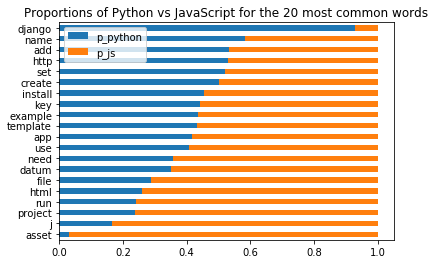

In [56]:
# figure out the percentage of language distribution
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_js=word_counts.js / word_counts['all']
        )
 .sort_values(by='all')
 [['p_python',
   'p_js'
  ]]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportions of Python vs JavaScript for the 20 most common words')

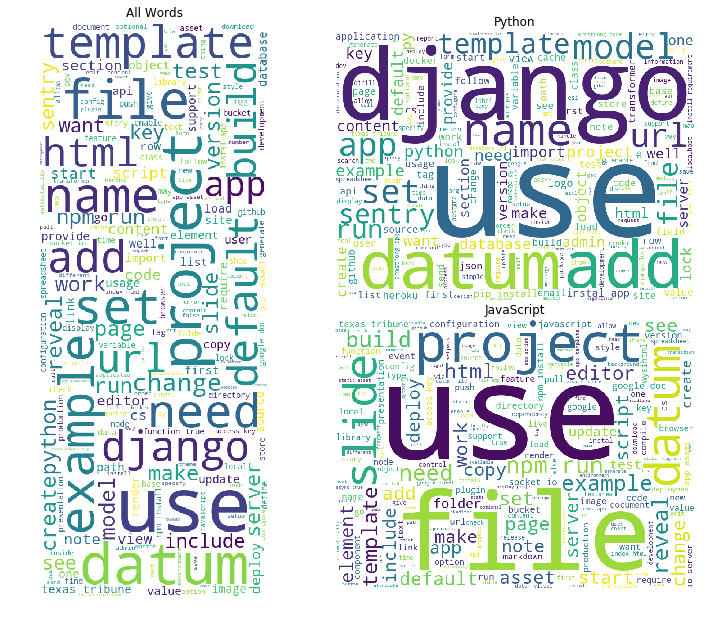

In [57]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
python_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(python_words))
js_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(js_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(python_cloud)
axs[2].imshow(js_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Python')
axs[2].set_title('JavaScript')

for ax in axs: ax.axis('off')

In [58]:
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(instal, app)       36
(pip, install)      34
(texas, tribune)    24
(http, www)         23
(manage, py)        23
dtype: int64

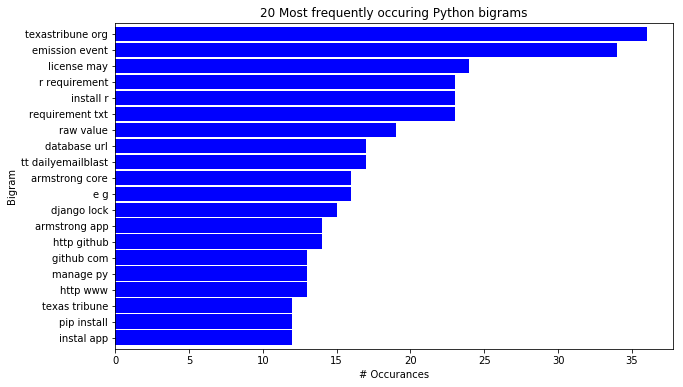

In [59]:
top_20_python_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

(-0.5, 1199.5, 799.5, -0.5)

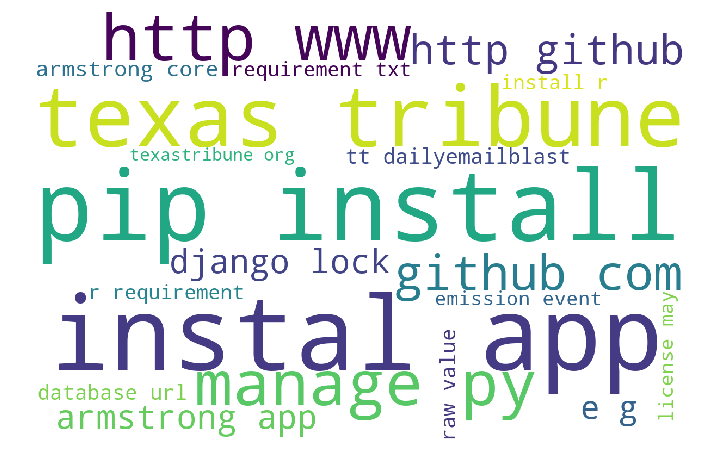

In [60]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img_python = WordCloud(background_color='white', width=1200, height=800).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img_python)
plt.axis('off')

In [61]:
top_20_js_bigrams = (pd.Series(nltk.ngrams(js_words, 2))
                      .value_counts()
                      .head(20))

top_20_js_bigrams.head()

(npm, run)        89
(reveal, j)       43
(google, doc)     40
(npm, install)    36
(socket, io)      35
dtype: int64

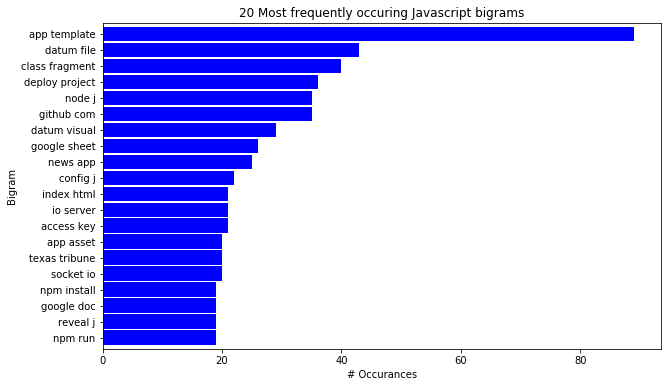

In [62]:
top_20_js_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Javascript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_js_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

(-0.5, 1199.5, 799.5, -0.5)

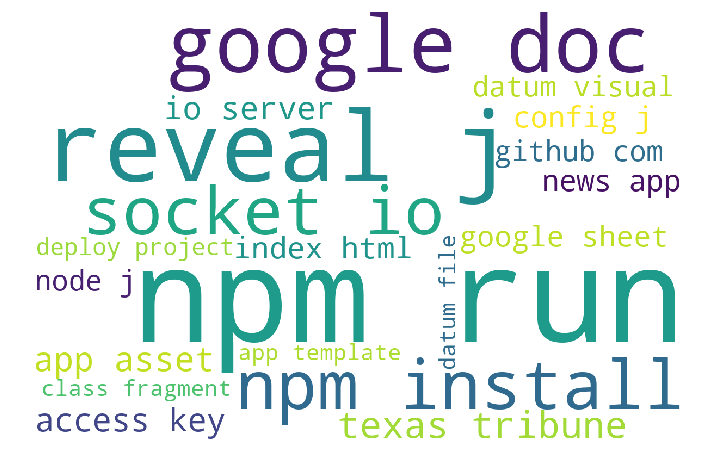

In [63]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_js_bigrams.to_dict().items()}
img_js = WordCloud(background_color='white', width=1200, height=800).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img_js)
plt.axis('off')

In [64]:
top_20_python_trigrams = (pd.Series(nltk.ngrams(python_words, 3))
                      .value_counts()
                      .head(20))

top_20_python_trigrams.head()

(http, github, com)          19
(pip, install, r)            13
(install, r, requirement)    13
(armstrong, core, arm)       11
(rio, grande, county)        11
dtype: int64

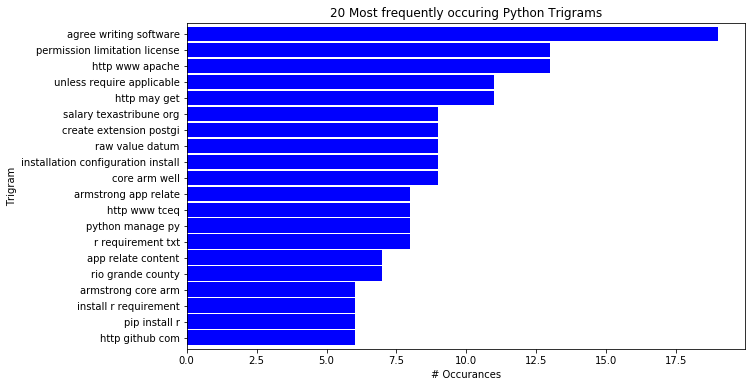

In [65]:
top_20_python_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

(-0.5, 1199.5, 799.5, -0.5)

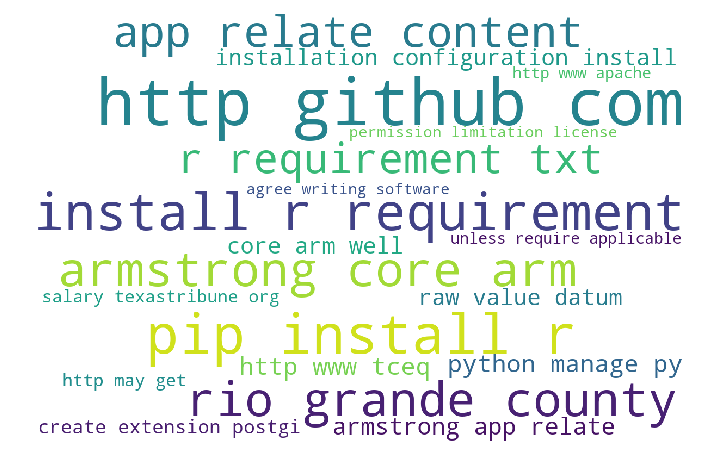

In [66]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_python_trigrams.to_dict().items()}
img_python_tri = WordCloud(background_color='white', width=1200, height=800).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img_python_tri)
plt.axis('off')

In [67]:
top_20_js_trigrams = (pd.Series(nltk.ngrams(js_words, 3))
                      .value_counts()
                      .head(20))

top_20_js_trigrams.head()

(socket, io, server)     25
(http, github, com)      18
(j, async, true)         18
(secret, access, key)    16
(npm, run, deploy)       16
dtype: int64

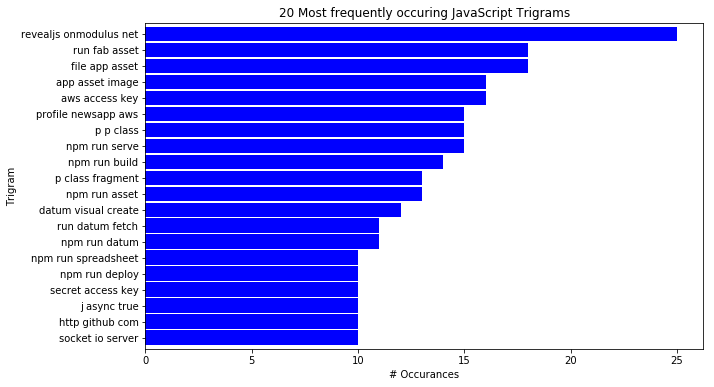

In [68]:
top_20_js_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_js_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

(-0.5, 1199.5, 799.5, -0.5)

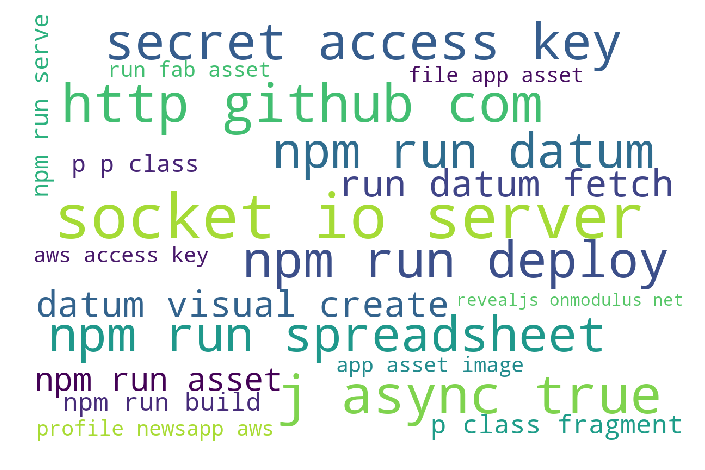

In [69]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_js_trigrams.to_dict().items()}
img_js_tri = WordCloud(background_color='white', width=1200, height=800).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img_js_tri)
plt.axis('off')

In [70]:
df.head()

,text,language
1,software collect donation nonprofit integrate ...,Python
2,datum visual create tool generate scaffolding ...,JavaScript
5,texas tribune file app app power file system t...,JavaScript
9,thermometer,Python
10,wall query salesforce opportunity information ...,Python


In [71]:
df_python = df[df.language == 'Python']
df_python.shape

(68, 2)

In [72]:
df_js = df[df.language == 'JavaScript']
df_js.shape

(60, 2)

In [73]:
def flatten(lofl):     
    for i in lofl: 
        if type(i) == list: 
            flatten(i) 
        else: 
            output.append(i)
    return output

In [74]:
string_python = []
for text in df_python.text.tolist():
    string_python.append(text.split())

In [75]:
output = []
words_in_python = pd.Series(flatten(string_python))
print(len(set(words_in_python)))

2304


In [76]:
string_js = []
for text in df_js.text.tolist():
    string_js.append(text.split())

In [77]:
output = []
words_in_js = pd.Series(flatten(string_js))
print(len(set(words_in_js)))

2258


# SENTIMENT ANALYSIS

In [78]:
afinn = Afinn()

In [79]:
afinn.score('This is amazingly awesome')

4.0

In [80]:
df.head()

,text,language
1,software collect donation nonprofit integrate ...,Python
2,datum visual create tool generate scaffolding ...,JavaScript
5,texas tribune file app app power file system t...,JavaScript
9,thermometer,Python
10,wall query salesforce opportunity information ...,Python


In [81]:
df['sentiment'] = df.text.apply(afinn.score)

In [82]:
df.head(20)

,text,language,sentiment
1,software collect donation nonprofit integrate ...,Python,19.0
2,datum visual create tool generate scaffolding ...,JavaScript,108.0
5,texas tribune file app app power file system t...,JavaScript,0.0
9,thermometer,Python,0.0
10,wall query salesforce opportunity information ...,Python,5.0
11,scuole italian school public school setup proj...,Python,7.0
14,geoip super simple node js base deployment get...,JavaScript,3.0
15,talk online comment break open source comment ...,JavaScript,27.0
16,rst tx salary django application generate use ...,Python,22.0
18,file,Python,0.0


In [83]:
df.groupby('language').sentiment.mean()

language
JavaScript    16.550000
Python         8.485294
Name: sentiment, dtype: float64

In [121]:
df_negative = df[df.sentiment < 0].reset_index().drop(columns=['index'])
df_negative

,text,language,sentiment
0,pass poison texas industrial polluter rarely f...,JavaScript,-4.0
1,iped importer purpose make easy interact iped ...,Python,-1.0
2,rst sentry heroku sentry realtime event loggin...,Python,-2.0
3,pymviewer single page site testing pym js embe...,JavaScript,-3.0
4,tx lobby early alpha datum two main source dat...,Python,-17.0
5,rst officeledger officeledger provide simple m...,Python,-3.0
6,rst django sentry sentry provide generic inter...,Python,-4.0


In [122]:
df_negative.iloc[4]['text']

"tx lobby early alpha datum two main source datum list register lobbyist year http www ethic state tx dfs loblist htm coversheet lobbyist activie report la http www ethic state tx dfs search lobby html name come source datum coversheet detail information name information lobby interest come registration form information enter hand hard use without scrub way de duplicate lobbying interest way regenerate lobbyist 's interest base raw registration datum store form amend often update good idea go back year get run set environment variable one way env file django setting module example project setting database url postgre tx lobby haystack url http optional want geocode https geoservice tamu edu service geocode webservice tamu api key f dcc b aa deb cf use autoenv source env activate install dep pip install r requirement txt npm install get database run postgre instruction createdb tx lobby simple postgre setup phd createdb complicated database url pip install postdoc inital migration make 

## 

# MODEL

In [84]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.text)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression(random_state=493).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [85]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 92.13%
---
Confusion Matrix
actual      JavaScript  Python
predicted                     
JavaScript          27       0
Python               7      55
---
              precision    recall  f1-score   support

  JavaScript       1.00      0.79      0.89        34
      Python       0.89      1.00      0.94        55

   micro avg       0.92      0.92      0.92        89
   macro avg       0.94      0.90      0.91        89
weighted avg       0.93      0.92      0.92        89



In [86]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 51.28%
---
Confusion Matrix
actual      JavaScript  Python
predicted                     
JavaScript           7       0
Python              19      13
---
              precision    recall  f1-score   support

  JavaScript       1.00      0.27      0.42        26
      Python       0.41      1.00      0.58        13

   micro avg       0.51      0.51      0.51        39
   macro avg       0.70      0.63      0.50        39
weighted avg       0.80      0.51      0.48        39



In [87]:
# for classificaiton you can change the algorithm as gini or entropy (information gain).  Default is gini.
clf = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=123)

In [88]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [89]:
y_pred = clf.predict(X_train)
y_pred[0:5]

array(['Python', 'Python', 'JavaScript', 'Python', 'Python'], dtype=object)

In [90]:
y_pred_proba = clf.predict_proba(X_train)

In [91]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.84


In [92]:
confusion_matrix(y_train, y_pred)

array([[20, 14],
       [ 0, 55]])

In [93]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.54


In [94]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [95]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [96]:
y_pred = knn.predict(X_train)

In [97]:
y_pred_proba = knn.predict_proba(X_train)

In [98]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.83


In [99]:
print(confusion_matrix(y_train, y_pred))

[[28  6]
 [ 9 46]]


In [100]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

  JavaScript       0.76      0.82      0.79        34
      Python       0.88      0.84      0.86        55

   micro avg       0.83      0.83      0.83        89
   macro avg       0.82      0.83      0.82        89
weighted avg       0.84      0.83      0.83        89



In [101]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.72


([<matplotlib.axis.XTick at 0x1a29eddcc0>,
 <a list of 5 Text xticklabel objects>)

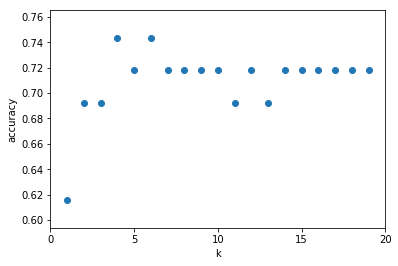

In [102]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

In [125]:
# Build a function that will take in the text of a README file, and makes a prediction of language.
def predict(unknown_text):
    return clf.predict(tfidf.transform([unknown_text]))[0]

In [126]:
corpus = get_github_repo('https://github.com/ecdedios/linear-logistic-regression')['readme']
predict(corpus)

'Python'